In [1]:
# Import required packages
import matplotlib as mpl
from matplotlib import colors

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) #this increases the inline figure size to 15 tall x 10 wide

import seaborn
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import pylab as pl
import adjustText as aT
import matplotlib as mtp

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed

import contextily as cx
from shapely.geometry import Polygon
from shapely.geometry import Point
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

/opt/anaconda3/envs/NCG613_Project/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
hp = gpd.read_file('hp.geojson') #2016 housing points with some additional factors calculated
lb = gpd.read_file('london_boroughs.geojson')
oa = gpd.read_file('OutputAreas.geojson')
sch = gpd.read_file('London_Schools.geojson')

In [3]:
hp.crs = {'init': 'epsg:27700'}
lb.crs = {'init': 'epsg:27700'}
oa.crs = {'init': 'epsg:27700'}
sch.crs = {'init': 'epsg:27700'}

In [4]:
oa = oa.rename(columns = {'NAME_2': 'NAME'}, inplace = False)

In [5]:
hp['Detached'] = np.where(hp['propertytype']=='D', 1, 0)
hp['Flats'] = np.where(hp['propertytype']=='F', 1, 0)
hp['Freehold'] = np.where(hp['duration']=='F', 1, 0)

In [6]:
hp2 = gpd.sjoin(hp,oa)
pd.set_option('display.max_columns', None)
hp2.head()

,ID,east,north,price,propertytype,duration,fl_area,No_Rooms,Price_Per_sqm,Postcode,logprice,log_fl_area,Dist_School,Dist_AcConv,Dist_FSM,Dist_Priv,Dist_Of1,Dist_Of12,Dist_Prim12,Dist_Sec12,Dist_VAS,Dist_AcSponsor,geometry,Detached,Flats,Freehold,index_right,geo_code,label,NAME,POP,POPDENS,HH,HECTARES,DEPRHH,EMPRES,STUDENT,PROFSCI,Trees,TreeDens
0,1,528925,157964,995000,D,F,288.0,7,3454.861111,CR5 3EZ,5.997823,2.459392,943.612208,1852.404114,1852.404114,943.612208,1972.702968,1303.989264,1303.989264,2733.169772,1303.989264,2733.169772,POINT (528925.000 157964.000),1,0,1,19031,E00005097,E92000001E09000008E00005097,Croydon,399.0,6.621308,133.0,60.26,0.375940,197,0.062914,0.127451,21.0,0.348490
16174,16175,529109,157935,720000,D,F,141.4,7,5091.937765,CR5 3EH,5.857332,2.150449,784.413794,1705.065981,1705.065981,784.413794,1795.243716,1291.652043,1291.652043,2547.375905,1291.652043,2547.375905,POINT (529109.000 157935.000),1,0,1,19031,E00005097,E92000001E09000008E00005097,Croydon,399.0,6.621308,133.0,60.26,0.375940,197,0.062914,0.127451,21.0,0.348490
17146,17147,529166,157845,535000,T,F,143.0,6,3741.258741,CR5 3EQ,5.728354,2.155336,681.558508,1705.221686,1705.221686,681.558508,1756.834938,1373.847881,1373.847881,2472.446764,1373.847881,2472.446764,POINT (529166.000 157845.000),0,0,1,19031,E00005097,E92000001E09000008E00005097,Croydon,399.0,6.621308,133.0,60.26,0.375940,197,0.062914,0.127451,21.0,0.348490
1,2,533634,180992,1300000,F,L,140.0,3,9285.714286,EC3N 1NT,6.113943,2.146128,249.353163,1398.845953,543.945769,479.688441,249.353163,249.353163,249.353163,1133.884033,249.353163,2112.389405,POINT (533634.000 180992.000),0,1,0,12112,E00000029,E92000001E41000324E00000029,City of London,225.0,14.696280,127.0,15.31,0.740157,125,0.095000,0.136364,110.0,7.184847
29,30,533634,180992,680000,F,L,84.0,3,8095.238095,EC3N 1NT,5.832509,1.924279,249.353163,1398.845953,543.945769,479.688441,249.353163,249.353163,249.353163,1133.884033,249.353163,2112.389405,POINT (533634.000 180992.000),0,1,0,12112,E00000029,E92000001E41000324E00000029,City of London,225.0,14.696280,127.0,15.31,0.740157,125,0.095000,0.136364,110.0,7.184847


In [7]:
variable_names = ['log_fl_area', 'No_Rooms', 'Flats', 'Detached', 'DEPRHH']

In [8]:
# Calculating log versions of all distances
hp2['Log_Dist_School'] = np.log(hp2['Dist_School']+1)
hp2['Log_Dist_AcSponsor'] = np.log(hp2['Dist_AcSponsor']+1)
hp2['Log_Dist_FSM'] = np.log(hp2['Dist_FSM']+1)
hp2['Log_Dist_Priv'] = np.log(hp2['Dist_Priv']+1)
hp2['Log_Dist_Of1'] = np.log(hp2['Dist_Of1']+1)
hp2['Log_Dist_Of12'] = np.log(hp2['Dist_Of12']+1)
hp2['Log_Dist_Prim12'] = np.log(hp2['Dist_Prim12']+1)
hp2['Log_Dist_Sec12'] = np.log(hp2['Dist_Sec12']+1)
hp2['Log_Dist_VAS'] = np.log(hp2['Dist_VAS']+1)

In [9]:
m1 = spreg.OLS(hp2[['logprice']].values, hp2[variable_names].values,
                name_y='logprice', name_x=variable_names, robust='white')
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    logprice                Number of Observations:       70925
Mean dependent var  :      5.6704                Number of Variables   :           6
S.D. dependent var  :      0.2493                Degrees of Freedom    :       70919
R-squared           :      0.5826
Adjusted R-squared  :      0.5826
Sum squared residual:    1839.678                F-statistic           :  19801.2975
Sigma-square        :       0.026                Prob(F-statistic)     :           0
S.E. of regression  :       0.161                Log likelihood        :   28871.984
Sigma-square ML     :       0.026                Akaike info criterion :  -57731.969
S.E of regression ML:      0.1611                Schwarz criterion     :  -57676.953

White Standard Errors
-------------------------------------------------------

In [10]:
hp2['residual'] = m1.u
medians = hp2.groupby("NAME").residual.median().to_frame('hood_residual')

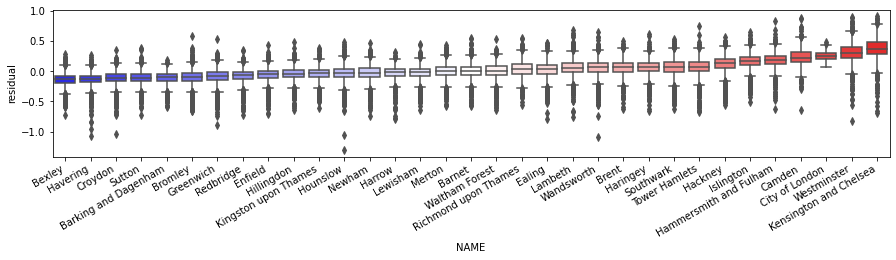

In [11]:
f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot('NAME', 'residual', ax = ax,
                data=hp2.merge(medians, how='left',
                              left_on='NAME',
                              right_index=True)
                   .sort_values('hood_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [12]:
w = weights.DistanceBand.from_dataframe(hp2, 500) # Weights based on features within 500 meters

In [13]:
f = 'logprice ~ ' + ' + '.join(variable_names) + ' + NAME - 1' # Remove intercept (-1) in this fixed effects model
print(f)

logprice ~ log_fl_area + No_Rooms + Flats + Detached + DEPRHH + NAME - 1


In [14]:
m2 = sm.ols(f, data=hp2).fit()
print(m2.summary2())

                       Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.811       
Dependent Variable:    logprice            AIC:                   -113014.7546
Date:                  2021-05-07 12:37    BIC:                   -112666.6341
No. Observations:      70338               Log-Likelihood:        56545.      
Df Model:              37                  F-statistic:           8133.       
Df Residuals:          70300               Prob (F-statistic):    0.00        
R-squared:             0.811               Scale:                 0.011735    
------------------------------------------------------------------------------
                              Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
NAME[Barking and Dagenham]    4.4922   0.0082  549.5767 0.0000  4.4761  4.5082
NAME[Barnet]                  4.6460   0.0079  585.8263 0.0000  4.6304  4.66

In [15]:
neighborhood_effects = m2.params.filter(like='NAME')
#neighborhood_effects.head()

In [16]:
stripped = neighborhood_effects.index.str.strip('NAME[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
#neighborhood_effects.head()

In [17]:
neighborhood_effects['NAME'] = neighborhood_effects.index

In [48]:
base_names = variable_names
dist_names = variable_names + ['Log_Dist_Of12']
# + ['Dist_School']
# + ['Dist_AcSponsor']
# + ['Dist_FSM']
# + ['Dist_Priv']
# + ['Dist_Of1']
# + ['Dist_Of12']
# + ['Dist_Prim12']
# + ['Dist_Sec12']
# + ['Dist_VAS']

# + ['Log_Dist_School']
# + ['Log_Dist_AcSponsor']
# + ['Log_Dist_FSM']
# + ['Log_Dist_Priv']
# + ['Log_Dist_Of1']
# + ['Log_Dist_Of12']
# + ['Log_Dist_Prim12']
# + ['Log_Dist_Sec12']
# + ['Log_Dist_VAS']

In [49]:
m3 = spreg.OLS(hp2[['logprice']].values, hp2[dist_names].values,
                name_y='logprice', name_x=dist_names, robust='white')
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    logprice                Number of Observations:       70925
Mean dependent var  :      5.6704                Number of Variables   :           7
S.D. dependent var  :      0.2493                Degrees of Freedom    :       70918
R-squared           :      0.6024
Adjusted R-squared  :      0.6023
Sum squared residual:    1752.821                F-statistic           :  17904.2099
Sigma-square        :       0.025                Prob(F-statistic)     :           0
S.E. of regression  :       0.157                Log likelihood        :   30587.099
Sigma-square ML     :       0.025                Akaike info criterion :  -61160.199
S.E of regression ML:      0.1572                Schwarz criterion     :  -61096.013

White Standard Errors
-------------------------------------------------------

In [50]:
m4 = spreg.OLS(hp2[['logprice']].values, hp2[dist_names].values,
                name_y='logprice', name_x=dist_names, robust='white', w=w, spat_diag=True, moran=True)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:       70925
Mean dependent var  :      5.6704                Number of Variables   :           7
S.D. dependent var  :      0.2493                Degrees of Freedom    :       70918
R-squared           :      0.6024
Adjusted R-squared  :      0.6023
Sum squared residual:    1752.821                F-statistic           :  17904.2099
Sigma-square        :       0.025                Prob(F-statistic)     :           0
S.E. of regression  :       0.157                Log likelihood        :   30587.099
Sigma-square ML     :       0.025                Akaike info criterion :  -61160.199
S.E of regression ML:      0.1572                Schwarz criterion     :  -61096.013

White Standard Errors
-------------------------------------------------------

## Spatial Lag Model (SAR)

In [51]:
m5 = spreg.GM_Lag(hp2[['logprice']].values, hp2[dist_names].values,
                     w=w, name_y='logprice', name_x=dist_names, robust='white')
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:       70925
Mean dependent var  :      5.6704                Number of Variables   :           8
S.D. dependent var  :      0.2493                Degrees of Freedom    :       70917
Pseudo R-squared    :      0.6294
Spatial Pseudo R-squared:  0.6228

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.3823860       0.0153054     286.3292933       0.0000000
         log_fl_area       0.8606709       0.0080614     106.7638666       0.0000000
            No_Rooms       0.0061345 

## Spatial Error Model (SEM)

In [52]:
m6 = spreg.GM_Error_Het(hp2[['logprice']].values, hp2[dist_names].values,
                     w=w, name_y='logprice', name_x=dist_names)
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:       70925
Mean dependent var  :      5.6704                Number of Variables   :           7
S.D. dependent var  :      0.2493                Degrees of Freedom    :       70918
Pseudo R-squared    :      0.6024
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.5744942       0.0154941     295.2417238       0.0000000
         log_fl_area       0.8687724       0.0083288     104.3098221       0.00

## Spatial Lag + Error Model (SARMA)

In [53]:
m7 = spreg.GM_Combo_Het(hp2[['logprice']].values, hp2[dist_names].values,
                     w=w, name_y='logprice', name_x=dist_names)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:       70925
Mean dependent var  :      5.6704                Number of Variables   :           8
S.D. dependent var  :      0.2493                Degrees of Freedom    :       70917
Pseudo R-squared    :      0.6294
Spatial Pseudo R-squared:  0.6228
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.3823860       0.0153054     286.3292933       0.0000000
         log_fl_area     

## Spatial Regimes Models

In [54]:
hpcam = hp2[(hp2["NAME"]=="Camden")]
wcam = weights.DistanceBand.from_dataframe(hpcam, 500)
m7cam = spreg.GM_Error_Het(hpcam[['logprice']].values, hpcam[dist_names].values,
                     w=wcam, name_y='logprice', name_x=dist_names)
print(m7cam.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:        1315
Mean dependent var  :      5.9246                Number of Variables   :           7
S.D. dependent var  :      0.2912                Degrees of Freedom    :        1308
Pseudo R-squared    :      0.8267
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4591949       0.0739212      60.3236617       0.0000000
         log_fl_area       0.7717698       0.0322521      23.9293079       0.00

In [55]:
hpbd = hp2[(hp2["NAME"]=="Barking and Dagenham")]
wbd = weights.DistanceBand.from_dataframe(hpbd, 500)
m7bd = spreg.GM_Error_Het(hpbd[['logprice']].values, hpbd[dist_names].values,
                     w=wbd, name_y='logprice', name_x=dist_names)
print(m7bd.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:        1718
Mean dependent var  :      5.4417                Number of Variables   :           7
S.D. dependent var  :      0.1305                Degrees of Freedom    :        1711
Pseudo R-squared    :      0.6807
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.8492667       0.0519580      93.3304620       0.0000000
         log_fl_area       0.3573544       0.0284776      12.5486043       0.00

In [56]:
hpken = hp2[(hp2["NAME"]=="Kensington and Chelsea")]
wken = weights.DistanceBand.from_dataframe(hpken, 500)
m7ken = spreg.GM_Error_Het(hpken[['logprice']].values, hpken[dist_names].values,
                     w=wken, name_y='logprice', name_x=dist_names)
print(m7ken.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:        1182
Mean dependent var  :      6.1308                Number of Variables   :           7
S.D. dependent var  :      0.3638                Degrees of Freedom    :        1175
Pseudo R-squared    :      0.8183
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4124426       0.0783811      56.2947260       0.0000000
         log_fl_area       0.9944533       0.0361365      27.5193930       0.00

In [57]:
hphack = hp2[(hp2["NAME"]=="Hackney")]
whack = weights.DistanceBand.from_dataframe(hphack, 500)
m7hack = spreg.GM_Error_Het(hphack[['logprice']].values, hphack[dist_names].values,
                     w=whack, name_y='logprice', name_x=dist_names)
print(m7hack.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    logprice                Number of Observations:        1390
Mean dependent var  :      5.7244                Number of Variables   :           7
S.D. dependent var  :      0.2220                Degrees of Freedom    :        1383
Pseudo R-squared    :      0.6705
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.7313902       0.0691273      68.4445677       0.0000000
         log_fl_area       0.6672682       0.0344602      19.3634723       0.00